# Projet Lignes de niveau

On importe ces modules par principe de precaution

In [16]:
import autograd
from autograd import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline

 Ceci est le notebook Jupyter contenant le projet de dessin de lignes de niveau sous python de Maud Roux-Salembien et Jérémy Costanzo

Soit f une fonction de $[0,1]^2$ vers $\mathbb{R}$ supposée continuement différentiable.

On cherche les ensembles de la forme : {$(x,y)\in\mathbb{R}^2|f(x,y)=c$} où c $\in$ $\mathbb{R}$



## <u>Contour simple</u>

### Amorce : 

Soit c $\in$ $\mathbb{R}$

On cherche une condition suffisante sur f(0,0) et f(0,1) pour qu'il existe t $\in$ [0,1] tel que f(0,t) = c

On sait que f est continuement différentiable, donc en particulier f(0,.), qui désigne la fonction $\begin{align*}
  [0,1] &\to \mathbb{R}\\
  t &\mapsto f(0,t).
\end{align*}$
est continue.


Ainsi, si c appartient au segment [min(f(0,0),f(0,1)),max(f(0,0),f(0,1))], le théorème des valeurs intermédiaires nous assure l'existence d'un t $\in$ [0,1] solution de f(0,t) = c.

Si la condition évoquée est satisfaite, on peut chercher numériquement une solution en utilisant la méthode de la dichotomie :

In [17]:
def find_seed(g,c=0,eps=2**(-26)):
    if (g(0)-c)*(g(1)-c) > 0:
        return None
    else:
        a = 0
        b = 1
        while b-a > eps:
            m = (a+b)/2
            if (g(m)-c)*(g(a)-c)<=0:
                b = m
            else:
                a = m
        t = (a+b)/2
        return t

La méthode des tangentes de Newton converge plus rapidement, mais nécessite plus d'hypothèses, et on ne peut pas savoir à quel point on est éloigné d'une solution, alors que la méthode de la dichotomie ne nécessite que la continuité de g, et permet de majorer la distance à une solution.

### Propagation

Une première approche pour implémenter la fonction simple_contour consisterait à subdiviser [0,1] en segments de taille $\delta$, et d'utiliser find_seed(g,c,eps) où g est la fonction $\begin{align*}
  [0,1] &\to \mathbb{R}\\
  t &\mapsto f(k\delta,t)
\end{align*}$ où k varie de 0 à int(1/$\delta$). Mais cela n'est pas satisfaisant, car l'équation f(k$\delta$,t) = c peut admettre plusieurs solutions éloignées les unes des autres.

Ceci est l'implémentation de la classe pt, qui permet de représenter des points et des vecteurs.

In [18]:
tolerance = 1**(-7) #un petit flottant

class pt:
    def __init__(self,x=0.0,y=0.0):
        self.x = x
        self.y = y
    
    def __repr__(self):
        return('{'+str(self.x)+','+str(self.y)+'}')
        
    def __mul__(a,b):
        if isinstance(b,int) or isinstance(b,float):
            return pt(a.x*b,a.y*b)
        else:
            return pt(a.x*b.x,a.y*b.y)
            
    def __rmul__(a,b):
        if isinstance(a,int) or isinstance(a,float):
            return pt(a*b.x,a*b.y)
        else:
            return a*b
    def __neg__(self):
        return pt(-self.x,-self.y)
        
    def __add__(a,b):
        return pt(a.x+b.x,a.y+b.y)  
    
    def __inv__(self):
        return pt(1/self.x,1/self.y)
    
    def __div__(self,b):
        return (self * (1/b))
    
    def __rdiv__(self,b):
        return pt(b.x/self,b.y/self)
    
    def norme(self):
        return (self.x**2 + self.y**2)**0.5

    def normalized(self):
        return(self*(1/(self.norme())))
        
    def __sub__(self,b):
        return self+ (-b)
        
    def orth(self):
        return pt(-self.y,self.x)

def list_x_y(p):
    x,y = [],[]
    for i in p:
        x.append(i.x)
        y.append(i.y)
    return(np.array(x),np.array(y))
    
def dist(a,b):
    return (a-b).norme()
    
def grad(f,p=pt()):
    autog = autograd.grad
    t = np.r_[autog(f,0)(p.x,p.y),autog(f,1)(p.x,p.y)]
    return pt(t[0],t[1])

Nous implementons maintenant la fonction ingrid : ingrid(p,grid) renvoie : p $\in$ grid ou grid est en fait un ensemble de la forme [a,b]x[c,d] où (a,b,c,d) $\in \mathbb{R}^4$.

In [19]:
def ingrid(p,grid):
    return(grid[0]<=p.x<=grid[1] and grid[2]<=p.y<=grid[3])    

Notre première implémentation se basait uniquement sur une methode qui utilise le gradient : on a calculé un point de la ligne de niveau, on suit l'orthogonal du gradient de norme delta dans la direction qui ne nous fait pas revenir en arrière (le point parmis les deux possibles qui est le plus loin de celui qu'on avait calculé avant), et on continue ainsi.
Mais cette méthode propage les erreurs, car rien n'assure qu'on reste sur la ligne de niveau, même si les résultats obtenus sont plutot satisfaisants pour des fonctions assez régulières si delta est petit. 

Les fonctions suivantes permettent de se reperer sur un cercle de rayon delta centre sur un point p0.

In [20]:
def p_a1(ang):
    """
    Cette fonction calcule le point p sur le cercle unite tel que l'angle oriente (pt(1,0),p) vale ang
    """
    return(pt(np.cos(ang),np.sin(ang)))    

def rad(p):
    """
    Cette fonction calcule l'angle oriente (pt(1,0),p)
    """
    pn = p.normalized()
    x = pn.x
    y = pn.y
    if y > 0:
        return np.arccos(x)
    else:
        return -np.arccos(x)
    
def theta(p0,p):
    """
    calcule l'angle oriente (p0+pt(delta,0),p) ou delta = dist(p0,p)
    """
    return rad(p) - rad(p0)

def p_a(p0,th,delta):
    """
    calcule le point p tel que dist(p,p0) = delta et theta(p0,p) = th
    """
    p = delta*p_a1(th)
    return(p0+p)

Nous avons d'abord pensé à utiliser la méthode de newton à une dimension. Pour cela on cherche le point $n+1$ de la suite dans un cercle de rayon delta autour du point n. Chaque point du cercle est alors défini par un angle $\theta$, compté dans le sens direct. En utilisant la relation entre $\theta$ et les coordonnées du point $(x,y)$ sur le cerle on définit une fonction d'une variable $g(\theta)=f(x,y)$ pour tout $(x,y)$ dans le cercle qui nous intéresse. On applique alors la méthode de newton à la fonction $g$ : on contruit une suite $(\theta_{n})$ telle que $\theta_{n+1} = \theta_{n} - \frac{g(\theta_{n}) - c}{g'(\theta_{n})}$ qui converge vers $\theta$ tel que $g(\theta) - c = 0$. 
Pour les conversions entre point et angle on utilise les fonctions précédentes.

La fonction suivant permet d'obtenir une première approximation du point $n+1$ en utilisant la méthode du gradient. Elle prend en argument f la fonction dont on veut tracer les lignes de niveau, ad l'avant-dernier point de notre liste de points, d le dernier point calculé, delta la distance entre deux points de la suite et grid la grille dont on ne doit pas sortir pour tracer les lignes de niveau. L'hortogonal au gradient nous donne deux directions dans lesquelles nous pouvons aller (dans la majorité des cas, sauf point particulier). Afin d'éviter de revenir sur nos pas nous choisissons celle qui nous amène le plus loin de l'avant-dernier point. 

In [21]:
def suivant(f, ad, d, delta, grid):
    h=grad(f,d[0])
    p11 = d[0] + (h.normalized().orth() * delta)
    p12 = d[0] - (h.normalized().orth() * delta)   #on utilise le gradient pour aller au prochain point  
    p1=pt()                                               #mais sans sortir de la grille

    if dist(ad[0], p11)> dist(ad[0], p12):
        if ingrid(p11,grid):
            p1=p11
        else:
            raise ValueError("on sort de la grille")           
    else:
        if ingrid(p12,grid):
            p1=p12
        else:
            raise ValueError("on sort de la grille")
    prochain=theta(d[0],p1)
    return((p1,prochain))

On corrige ensuite la valeur obtenue en utlisant la méthode des tangentes de Newton à la fonction g définie plus haut. 
On se place dans un cercle de rayon delta autour de du dernier point de la liste, le point obtenu grâce à suivant 
est le premier de la suite. 
On définit g et sa dérivée dg. Elles prennent pour argument $x$ le dernier point de la liste (on cherche le nouveau point dans un cercle de rayon delta autour de $x$), $\theta_{n}$ l'angle entre le point $x_{n}$ de la suite de Newton et $x$, $d$ le rayon du cercle et revoient $g(\theta_{n})$ (resp. $dg(\theta_{n})$).

In [22]:
def g(x, theta, d=0.01) :
    return f(x.x+d*np.cos(theta), x.y+d*np.sin(theta))
def dg(x, theta, d=0.01):
    return (-d*np.sin(theta)*autograd.grad(f,0)(x.x+d*np.cos(theta),x.y+d*np.sin(theta)) + d*np.cos(theta)*autograd.grad(f,1)(x.x+d*np.cos(theta),x.y+d*np.sin(theta)))

Voici la fonction Newton qui prend en argument $r$ le centre du cercle dans lequel on cherche le prochain point, $d = [x_{n},\theta_{n}]$, $delta$ le rayon du cercle, $c$ la valeur qu'a la fonction sur la ligne de niveau et renvoie $d = [x_{n+1},\theta_{n+1}]$

In [23]:
def newton(r, d, delta, c):
    derivee=dg(r, d[1],delta)                                  
    if abs(derivee) < 10**(-26):
        print("la dérivée est trop petite") #si la dérivée s'annule on renvoie la dernière valeur calculée avec Newton
        return (d[0],d[1])                                  
    else:
        return (p_a(r, d[1]-(g(r, d[1],delta) - c)/derivee, delta),d[1]-(g(r,d[1],delta) - c)/derivee)

On peut maintenant écrire simple_contour_un. Elle prend en arguments $f$ dont on trace la ligne de niveau, $c$ la valeur de $f$ sur cette ligne, $delta$ la distance entre deux points consécutifs de la ligne, $grid$ la grille dans laquelle on trace la ligne de niveau et $cote$ la fonction qui indique sur quel côté de la grille chercher le premier point de la ligne de niveau.

In [26]:
def simple_contour_un(f, cote, c=0.0,delta=0.01,grid=[0.,1.,0.,1.]):
    t = find_seed(cote,c)
    if t == None:
        return [],[]
    p0 = pt(grid[0],find_seed(cote,c))
    g0 = grad(f,p=p0)
    p11 = p0 + (g0.normalized().orth() * delta)
    p12 = p0 - (g0.normalized().orth() * delta)

    p1 = pt()
    
    if ingrid(p11,grid):
        p1 = p11
    elif ingrid(p12,grid):
        p1 = p12
    else:
        return [],[]
    
    t1=theta(p0,p1) #pi --> point    ti --> angle
    
    p2, t2 = newton(p1, [p1, t1], delta, c)
    
    pa = p0 #avant-avant dernier point calculé
    ta = 0.
    pb = p1 #avant-dernier
    tb = t1
    pc = p2 #dernier point calculé
    tc = t2
    
    pts=[p0, p1]
    ref=p1  #ref représente le dernier point enregistré dans la liste. On cherche le prochain point dans un cercle 
                #de rayon delta, en première approximation avec suivant puis en corrigeant grâce à newton

    try :
        while dist(pc,pa) >= delta/2 and len(pts)<10000:
        
            pb, tb = newton(ref, [pa,ta], delta, c)
            pc, tc = newton(ref, [pb,tb], delta, c)

            while dist(pc,pb)>10**(-15):
                pa = pb    
                ta = tb
                pb = pc
                tb = tc
                pc, tc = newton(ref, [pb,tb], delta, c)  #on cherche le point sur le cercle avec newton
  
            if not ingrid(pc,grid):
                return list_x_y(pts)
            else:
                pd = pts[-1]
                td = theta(pts[-2],pd)
                ref = pc
                pts.append(pc)
                pa, ta = suivant(f, [pd,td], [pc,tc], delta, grid) #on change de point avec suivant
 
    except ValueError as e:
        print(e)
    return list_x_y(pts)

Cependant cette fonction ne marche pas dans tous les cas et nous n'avons pas réussi à la débugger :

on sort de la grille
on sort de la grille


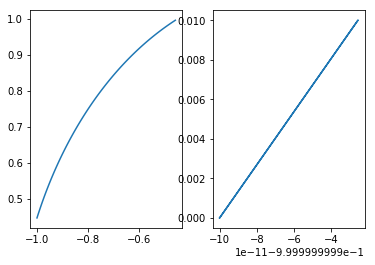

In [27]:
def f(x,y):
    return(x**2+y**2)

plt.axis('equal')
grid1=[-1.,1.,-1.,1.]

s=simple_contour_un(f, lambda x:f(grid1[0],x), c=1.2, grid=grid1)
s1=simple_contour_un(f, lambda x:f(grid1[0],x), c=1., grid=grid1)
plt.subplot(1,2,1)
plt.plot(s[0],s[1])
plt.subplot(1,2,2)
plt.plot(s1[0],s1[1]) #on remarque que le trait de la figure 2 est plus épais : on est revenus sur nos pas... 
                       #et on est sortis de la grille en ayant calculé peut de points

Une autre idée consiste à travailler avec le gradient de f pour se rapprocher de la ligne de niveau.

On utilise une méthode semblable à la méthode de Newton en dimension 1, cette methode est d'ailleurs une généralisation si on considère $\mathbb{R}$ comme un espace vectoriel de dimension 1, et en identifiant $\frac{1}{f'}$ à $\frac{\nabla f(p_{0})}{\|\nabla f(p_{0})\|^2}$.

Le principe est le suivant : soit $p_{0}$ $\in \mathbb{R}^2$ , et $f$ : $\mathbb{R}^2 \rightarrow \mathbb{R}$, continuement différentiable. 

On cherche h tel que $f$($p_{0}$ + h) = $o$(h). On ne peut pas vraiment aller plus loin car $f$ est seulement supposée continuement différentiable. 

On sait que $f(p_{0}+h) = f(p_{0}) + <\nabla f(p_{0})|h> + o(h)$.

Ainsi, si $\nabla f(p_{0}) \ne 0$, il suffit de poser $h(p_{0}) = \frac{-f(p_{0}) * \nabla f(p_{0})}{\|\nabla f(p_{0})\|^2}$.

On peut ainsi créer une suite qui est sensée converger vers une solution $s$ de l'équation $f(x) = 0$ en posant $p_{0}$ un point proche de la ligne de niveau (obtenu par exemple en suivant l'orthogonal du gradient), et en posant pour tout $n \in \mathbb{N}, p_{n+1} = p_{n+1} + h(p_{n})$.

In [28]:
def newton2d(f,p0,c,eps=10**-4):
    def fun(x,y):
        return (f(x,y)-c)
    def proch(p): #proch joue le role de l'application contractante pour l'application du theoreme du point fixe
        g = grad(f,p)
        return(p - (fun(p.x,p.y)/(g.norme()**2))*g)
    p1 = proch(p0)
    while dist(p0,p1) > eps:
        p0 = p1
        p1 = proch(p1)
    return(p1)

Malheureusement, cette solution ne produit pas de résultat satisfaisant, car rien ne garantit qu'on ne revient pas en arrière sur la ligne de niveau, c'est à dire qu'on a calculé des points de la ligne de niveau, le dernier calculé étant $p_{n}$, et l'avant dernier $p_{n-1}$. On veut calculer $p_{n+1}$, qui soit à peu près éloigné de delta de $p_{n}$. Mais cette méthode n'assure pas que $p_{n+1}$ ne soit pas proche de $p_{n-1}$...

Nous avons donc implémenté une méthode dichotomique.

Le principe de cette méthode est le suivant:

Le dernier point calculé est $p_{n}$, l'avant dernier point calculé est $p_{n-1}$.

On cherche $p_{n+1}$ sur une portion cercle de centre $p_{n}$ et de rayon delta par une méthode dichotomique.

Cette portion est définie ainsi : On pose $\theta_{0} = rad(p_{n}-p_{n-1})$, et on fait une recherche dichotomique classique sur $t \rightarrow g(f, p_{n},t + \theta_{0} , delta)$ sur un intervalle $[-\pi+\epsilon, \pi-\epsilon]$, ce qui assure que $p_{n+1} \ne p_{n-1}$ (si ce point existe, rien ne l'assure).

In [29]:
def g(f,p0,theta,d) :
    return f(p0.x+d*np.cos(theta),p0.y+d*np.sin(theta))

def dichotoproch(f,c,delta,ad,d):
    ang = rad(d-ad)
    def rech(th):
        return g(f,d,th+ang,delta)
    a = -np.pi + delta
    b =  np.pi - delta
    while b-a > delta:
        m = (a+b)/2
        if (rech(m)-c)*(rech(a)-c)<=0:
            b = m
        else:
            a = m
    t = (a+b)/2
    return p_a(d,t+ang,delta)

Il reste une subtilité. Cette méthode nécessite un avant dernier point... 
Comment calculer le deuxième point (le premier étant fourni par find_seed)?
Nous avons choisi de prendre le deuxième point en suivant l'orthogonal du gradient, cela fournit un point éloigné de delta du premier point, et proche de la ligne de niveau cherchée. Comme c'est le seul calculé de cette manière, il n'y a pas de problème de propagation des erreurs.

In [30]:
def simple_contour(f,c=0.0, delta =0.01,grid = [0.0,1.0,0.0,1.0],cote= lambda x: f(0.0,x),i = 0): #i designe le cote de la grille : il appartient à [|0,3|]
    t = find_seed(cote,c)
    if t == None:
        return [],[]
    p0 = pt()
    
    if i == 0:
        p0 = pt(grid[0],grid[2]+(grid[3]-grid[2])*t)
    elif i == 1:
        p0 = pt(grid[0]+(grid[1]-grid[0])*t,grid[3])
    elif i == 2:
        p0 = pt(grid[1],grid[2]+(grid[3]-grid[2])*t)
    elif i == 3:
        p0 = pt(grid[0]+(grid[1]-grid[0])*t,grid[2])
        
    g0 = grad(f,p0)
    p11 = p0 + (g0.normalized().orth() * delta)
    p12 = p0 - (g0.normalized().orth() * delta)
    p1 = pt()
    if ingrid(p11,grid):
        p1 = p11
    elif ingrid(p12,grid):
        p1 = p12
    else:
        return [],[]
    p2 = dichotoproch(f,c,delta,p0,p1)
    pts = [p0,p1,p2]
    pa = p0 #avant-avant dernier point calculé
    pb = p1 #avant-dernier
    pc = p2 #dernier point calculé
    compt = 0
    while dist(pc,p0) > delta and dist(pc,pa) > delta and compt < 100000:
        compt += 1
        pa = pb
        pb = pc
        pc = dichotoproch(f,c,delta,pa,pb)
        pts.append(pc)
        if not ingrid(pc,grid):
            return list_x_y(pts)
    return list_x_y(pts)    

grid, cote et i sont des arguments optionnels, utilisés par contour complexe.
Ils permettent de préciser sur quel côté de la grille on veut chercher une amorce : 

i = 0 signifie qu'on cherche une amorce sur la gauche de la grille.

i = 1 signifie qu'on cherche une amorce sur le haut de la grille.

i = 2 signifie qu'on cherche une amorce sur la droite de la grille.

i = 3 signifie qu'on cherche une amorce sur le bas de la grille.

## Contour complexe

On veut maintenant quadriller notre espace pour trouver des amorces ailleurs pour les lignes de niveau.
On va appeler contour_simple sur ces grilles.
On définit la fonction bord, qui renvoie une fonction $[0,1] \rightarrow \mathbb{R}$, qui va nous servir à trouver une amorce pour chacun des 4 côtés de la cellule.

In [31]:
def bord(f,grid,n):
                """
                bord(f,p1,p2,n) renvoie une application partielle qui va etre utilisee par find_seed pour trouver une amorce a une ligne de niveau.
                """
                if n == 0:
                    return(lambda t: f(grid[0],grid[2]+(grid[3]-grid[2])*t))
                elif n == 1:
                    return(lambda t: f(grid[0]+(grid[1]-grid[0])*t,grid[3]))
                elif n == 2:
                    return(lambda t: f(grid[1],grid[2]+(grid[3]-grid[2])*t))
                elif n == 3:
                    return(lambda t: f(grid[0]+(grid[1]-grid[0])*t,grid[2]))
            
def contour(f,c=0.0,xc=[0.0,1.0],yc=[0.0,1.0],delta = 0.01):
    xs,ys = [],[]
    for i in range(len(xc)-1):
        for j in range(len(yc)-1):
            grid = [xc[i],xc[i+1],yc[j],yc[j+1]]
            
            for n in range(4):    
                appp = bord(f,grid,n)
                x,y = simple_contour(f,c,delta,grid,appp,n)
                xs.append(x)
                ys.append(y)
    return(xs,ys)

Cette fonction pourrait être mieux optimisée : en général, quand une ligne de niveau entre par un côté d'une case, elle ressort par un côté différent. Il est alors inutile de chercher une amorce sur ce côté.
Cela pourrait améliorer la vitesse de l'algorithme d'un facteur 2.

In [32]:
def f(x,y):
    return x**2 + y**2

Contour simple : 

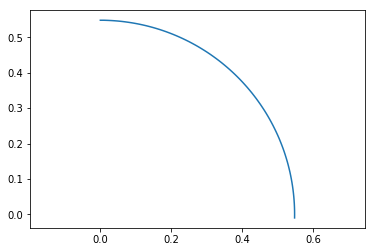

In [33]:
plt.axis("equal")
si = simple_contour(f,0.3)
plt.plot(si[0],si[1])
plt.show()

Contour complexe :

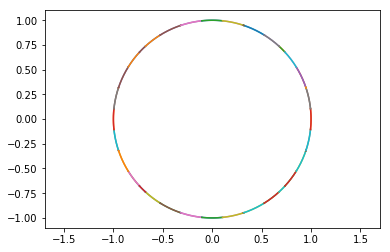

In [34]:
grille_x = np.linspace(-2,2,20)
grille_y = np.linspace(-2,2,20)

xs,ys = contour(f,1,grille_x,grille_y,0.001)

for x,y in zip(xs,ys):
    plt.plot(x,y)
plt.axis("equal")
plt.show()

## Conclusion

La méthode dichotomique semble fiable, puisqu'elle nous garantit de ne pas retourner sur nos pas.

En revanche, il faut s'assurer que l'on respecte les hypothèses du théorème des valeurs intermédiaires.

Ces conditions sont souvent respectées, mais ne le sont pas si on veut tracer les lignes de niveau d'un maximum ou d'un minimum local.
Mais cela produit aussi une annulation du gradient, donc il faudrait utiliser une methode plus complexe.